## Test for anisotropic water-table aquifer
**This test is taken from examples presented in MLU tutorial.**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ttim

Set basic parameters:

In [2]:
b = 10  # aquifer thickness in m
Q = 172.8  # constant discharge rate in m^3/d
rw = 0.1  # well radius in m
rc = 0.1  # casing radius in m

Load datasets of observation wells:

In [3]:
r1 = 3.16
r2 = 31.6
data0 = np.loadtxt("data/moench_pumped.txt", skiprows=1)
t0 = data0[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h0 = -data0[:, 1]
data1 = np.loadtxt("data/moench_ps1.txt", skiprows=1)
t1 = data1[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h1 = -data1[:, 1]
data2 = np.loadtxt("data/moench_pd1.txt", skiprows=1)
t2 = data2[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h2 = -data2[:, 1]
data3 = np.loadtxt("data/moench_ps2.txt", skiprows=1)
t3 = data3[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h3 = -data3[:, 1]
data4 = np.loadtxt("data/moench_pd2.txt", skiprows=1)
t4 = data4[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h4 = -data4[:, 1]

Check how well TTim can simulate drawdowns in a vertically anisotropic water-table aquifer:

In [4]:
# Set kaq, Saq, Sy and kzoverkh as given in Moench (1997)
kaq = 1e-4 * 60 * 60 * 24  # convert from m/s to m/d
Sy = 0.2
Saq = 2e-5
zh = 0.5  # kzoverkh

In [5]:
ml1 = ttim.Model3D(
    kaq=kaq,
    z=[0, -0.1, -2.1, -5.1, -10.1],
    Saq=[Sy, Saq, Saq, Saq],
    kzoverkh=zh,
    tmin=1e-5,
    tmax=3,
)
w1 = ttim.Well(ml1, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, Q)], layers=3)
ml1.solve()

self.neq  1
solution complete


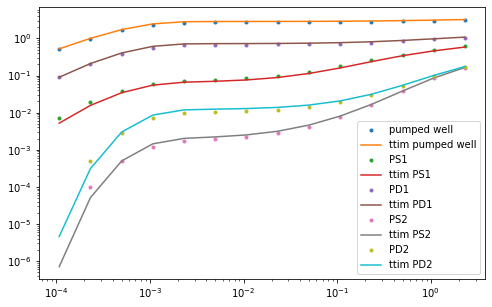

In [6]:
hm1 = ml1.head(r1, 0, t1, layers=1)[0]
hm2 = ml1.head(r1, 0, t2, layers=3)[0]
hm3 = ml1.head(r2, 0, t3, layers=1)[0]
hm4 = ml1.head(r2, 0, t4, layers=3)[0]
hm0 = ml1.head(0, 0, t0, layers=3)[0]
plt.figure(figsize=(8, 5))
plt.loglog(t0, -h0, ".", label="pumped well")
plt.loglog(t0, -hm0, label="ttim pumped well")
plt.loglog(t1, -h1, ".", label="PS1")
plt.loglog(t1, -hm1, label="ttim PS1")
plt.loglog(t2, -h2, ".", label="PD1")
plt.loglog(t2, -hm2, label="ttim PD1")
plt.loglog(t3, -h3, ".", label="PS2")
plt.loglog(t3, -hm3, label="ttim PS2")
plt.loglog(t4, -h4, ".", label="PD2")
plt.loglog(t4, -hm4, label="ttim PD2")
plt.legend();

In [7]:
res1 = 0
res2 = 0
res3 = 0
res4 = 0
res0 = 0
for i in range(len(h1)):
    r = (h1[i] - hm1[i]) ** 2
    res1 = res1 + r
for i in range(len(h2)):
    r = (h2[i] - hm2[i]) ** 2
    res2 = res2 + r
for i in range(len(h3)):
    r = (h3[i] - hm3[i]) ** 2
    res3 = res3 + r
for i in range(len(h4)):
    r = (h4[i] - hm4[i]) ** 2
    res4 = res4 + r
for i in range(len(h0)):
    r = (h0[i] - hm0[i]) ** 2
    res0 = res0 + r

n = len(h1) + len(h2) + len(h3) + len(h4) + len(h0)
residuals = res1 + res2 + res3 + res4 + res0
rmse = np.sqrt(residuals / n)
print("RMSE:", rmse)

RMSE: 0.06131800012056597


Try calibrating model to find the parameters:

In [8]:
ml2 = ttim.Model3D(
    kaq=1,
    z=[0, -0.1, -2.1, -5.1, -10.1],
    Saq=[0.1, 1e-4, 1e-4, 1e-4],
    kzoverkh=1,
    tmin=1e-5,
    tmax=3,
)
w2 = ttim.Well(ml2, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, Q)], layers=3)
ml2.solve()

self.neq  1
solution complete


In [9]:
ca2 = ttim.Calibrate(ml2)
ca2.set_parameter(name="kaq0_3", initial=1)
ca2.set_parameter(name="Saq0", initial=0.2)
ca2.set_parameter(name="Saq1_3", initial=1e-4, pmin=0)
ca2.set_parameter_by_reference(
    name="kzoverkh", parameter=ml2.aq.kzoverkh, initial=0.1, pmin=0
)
ca2.series(name="pumped", x=0, y=0, t=t0, h=h0, layer=3)
ca2.series(name="PS1", x=r1, y=0, t=t1, h=h1, layer=1)
ca2.series(name="PD1", x=r1, y=0, t=t2, h=h2, layer=3)
ca2.series(name="PS2", x=r2, y=0, t=t3, h=h3, layer=1)
ca2.series(name="PD2", x=r2, y=0, t=t4, h=h4, layer=3)
ca2.fit()

.......................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 70
    # variables        = 4
    chi-square         = 0.00754817
    reduced chi-square = 1.1437e-04
    Akaike info crit   = -631.446179
    Bayesian info crit = -622.452198
[[Variables]]
    kaq0_3:    9.06764582 +/- 0.02235169 (0.25%) (init = 1)
    Saq0:      0.17288491 +/- 0.00437293 (2.53%) (init = 0.2)
    Saq1_3:    3.8697e-05 +/- 3.5516e-06 (9.18%) (init = 0.0001)
    kzoverkh:  0.53505372 +/- 0.01014261 (1.90%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_3, kzoverkh) = -0.832
    C(kaq0_3, Saq0)     = -0.533
    C(Saq0, kzoverkh)   =  0.339
    C(Saq1_3, kzoverkh) = -0.127


In [10]:
display(ca2.parameters)
print("RMSE:", ca2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_3,9.06765,0.022352,0.246499,-inf,inf,1,"[9.067645818977368, 9.067645818977368, 9.06764..."
Saq0,0.172885,0.004373,2.52939,-inf,inf,0.2,[0.17288490900275638]
Saq1_3,3.86968e-05,0.000004,9.17789,0.0,inf,0.0001,"[3.86968110601682e-05, 3.86968110601682e-05, 3..."
kzoverkh,0.535054,0.010143,1.89563,0.0,inf,0.1,"[0.5350537166002225, 0.5350537166002225, 0.535..."


RMSE: 0.010384170446842922


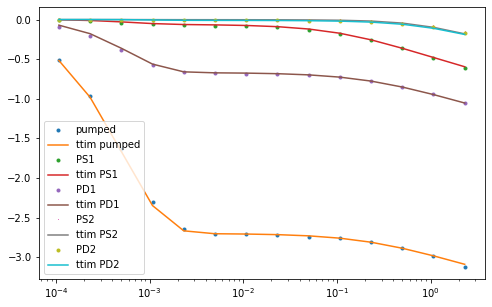

In [11]:
hm0_2 = ml2.head(0, 0, t0, layers=3)[0]
hm1_2 = ml2.head(r1, 0, t1, layers=1)[0]
hm2_2 = ml2.head(r1, 0, t2, layers=3)[0]
hm3_2 = ml2.head(r2, 0, t3, layers=1)[0]
hm4_2 = ml2.head(r2, 0, t4, layers=3)[0]
plt.figure(figsize=(8, 5))
plt.semilogx(t0, h0, ".", label="pumped")
plt.semilogx(t0, hm0_2, label="ttim pumped")
plt.semilogx(t1, h1, ".", label="PS1")
plt.semilogx(t1, hm1_2, label="ttim PS1")
plt.semilogx(t2, h2, ".", label="PD1")
plt.semilogx(t2, hm2_2, label="ttim PD1")
plt.semilogx(t3, h3, ",", label="PS2")
plt.semilogx(t3, hm3_2, label="ttim PS2")
plt.semilogx(t4, h4, ".", label="PD2")
plt.semilogx(t4, hm4_2, label="ttim PD2")
plt.legend();

Try calibrating model with stratified kaq:

In [12]:
ml3 = ttim.Model3D(
    kaq=1,
    z=[0, -0.1, -2.1, -5.1, -10.1],
    Saq=[0.1, 1e-4, 1e-4, 1e-4],
    kzoverkh=1,
    tmin=1e-5,
    tmax=3,
)
w3 = ttim.Well(ml3, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, Q)], layers=3)
ml3.solve()

self.neq  1
solution complete


In [13]:
ca3 = ttim.Calibrate(ml3)
ca3.set_parameter(name="kaq0", initial=1, pmin=0)
ca3.set_parameter(name="kaq1_3", initial=1)
ca3.set_parameter(name="Saq0", initial=0.2, pmin=0)
ca3.set_parameter(name="Saq1_3", initial=1e-4, pmin=0)
ca3.set_parameter_by_reference(
    name="kzoverkh", parameter=ml3.aq.kzoverkh, initial=0.1, pmin=0
)
ca3.series(name="pumped", x=0, y=0, t=t0, h=h0, layer=3)
ca3.series(name="PS1", x=r1, y=0, t=t1, h=h1, layer=1)
ca3.series(name="PD1", x=r1, y=0, t=t2, h=h2, layer=3)
ca3.series(name="PS2", x=r2, y=0, t=t3, h=h3, layer=1)
ca3.series(name="PD2", x=r2, y=0, t=t4, h=h4, layer=3)
ca3.fit()

.................................................................................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 206
    # data points      = 70
    # variables        = 5
    chi-square         = 0.00659115
    reduced chi-square = 1.0140e-04
    Akaike info crit   = -638.936637
    Bayesian info crit = -627.694160
[[Variables]]
    kaq0:      1.49295291 +/- 0.49139676 (32.91%) (init = 1)
    kaq1_3:    9.06775860 +/- 0.02107641 (0.23%) (init = 1)
    Saq0:      0.17644488 +/- 0.00419970 (2.38%) (init = 0.2)
    Saq1_3:    3.9420e-05 +/- 3.3278e-06 (8.44%) (init = 0.0001)
    kzoverkh:  0.54082429 +/- 0.01008878 (1.87%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq1_3, kzoverkh) = -0.808
    C(kaq1_3, Saq0)     = -0.533
    C(Saq0, kzoverkh)   =  0.365
    C(kaq0, kzo

In [14]:
display(ca3.parameters)
print("RMSE:", ca3.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,1.49295,0.491397,32.9144,0,inf,1,[1.4929529078613704]
kaq1_3,9.06776,0.021076,0.232432,-inf,inf,1,"[9.067758598328027, 9.067758598328027, 9.06775..."
Saq0,0.176445,0.004200,2.38018,0,inf,0.2,[0.1764448834100245]
Saq1_3,3.94203e-05,0.000003,8.44175,0,inf,0.0001,"[3.942033806425549e-05, 3.942033806425549e-05,..."
kzoverkh,0.540824,0.010089,1.86545,0,inf,0.1,"[0.5408242889145249, 0.5408242889145249, 0.540..."


RMSE: 0.00970356738147155


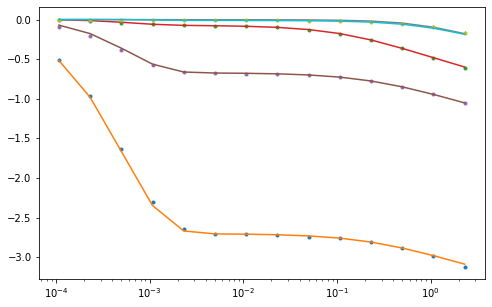

In [15]:
hm0_3 = ml3.head(0, 0, t0, layers=3)[0]
hm1_3 = ml3.head(r1, 0, t1, layers=1)[0]
hm2_3 = ml3.head(r1, 0, t2, layers=3)[0]
hm3_3 = ml3.head(r2, 0, t3, layers=1)[0]
hm4_3 = ml3.head(r2, 0, t4, layers=3)[0]
plt.figure(figsize=(8, 5))
plt.semilogx(t0, h0, ".", label="pumped")
plt.semilogx(t0, hm0_3, label="ttim pumped")
plt.semilogx(t1, h1, ".", label="PS1")
plt.semilogx(t1, hm1_3, label="ttim PS1")
plt.semilogx(t2, h2, ".", label="PD1")
plt.semilogx(t2, hm2_3, label="ttim PD1")
plt.semilogx(t3, h3, ",", label="PS2")
plt.semilogx(t3, hm3_3, label="ttim PS2")
plt.semilogx(t4, h4, ".", label="PD2")
plt.semilogx(t4, hm4_3, label="ttim PD2");

### Summary of calibrated values

In [16]:
ca3.parameters["optimal"].values

array([1.4929529078613704, 9.067758598328027, 0.1764448834100245,
       3.942033806425549e-05, 0.5408242889145249], dtype=object)

In [17]:
ta = pd.DataFrame(
    columns=["Moench", "TTim", "TTim-stratified"],
    index=["k0[m/d]", "k[m/d]", "Sy[-]", "Ss[1/m]", "kz/kh"],
)
ta.loc[:, "TTim-stratified"] = ca3.parameters["optimal"].values
ta.loc[1:, "TTim"] = ca2.parameters["optimal"].values
ta.loc[1:, "Moench"] = [8.640, 0.2, 2e-5, 0.5]
ta.loc["RMSE"] = [0.061318, ca2.rmse(), ca3.rmse()]
ta

,Moench,TTim,TTim-stratified
k0[m/d],NaN,NaN,1.49295
k[m/d],8.64,9.06765,9.06776
Sy[-],0.2,0.172885,0.176445
Ss[1/m],2e-05,3.86968e-05,3.94203e-05
kz/kh,0.5,0.535054,0.540824
RMSE,0.061318,0.0103842,0.00970357
